In [7]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.4: Evidence approximation

## Objectives

+ To demonstrate one can estimate the hyper-parameters of Bayesian model using the evidence approximation.

Get some data first:

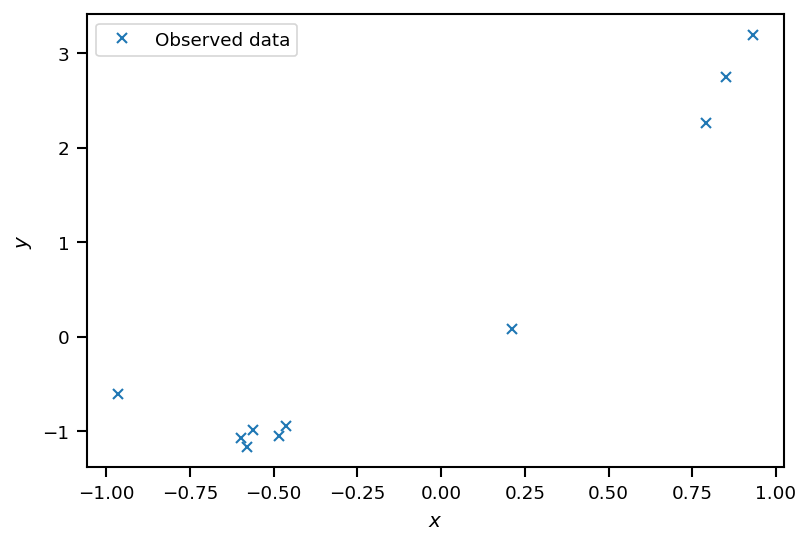

In [73]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [74]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We are not going to implement the evidence approximation from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge):

We are not going to implement the evidence approximation from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge).
Scikit-learn makes some default assumptions about the hyper-priors of $\sigma^2$ and $\alpha$.
You can change these assumptions if you wish (they assign a Gamma distribution to the inverse of these parameters).
However, these hyper-priors are generated under the assumption that the input-output pairs have been *normalized* before fitting.
To normalize the data, we subtract from the features and the outputs their empirical mean and we divide by their empirical standard deviation.
Then you do regression between normalized features and outputs and you make sure that you correctly transform the results of your analysis back to the original ones.
Scikit-learn makes all this super easy as you just need to pass a single argument that says that you want to normalize.
Here is how you do it:

In [92]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import BayesianRidge
# Select polynomial degree and get design matrix
degree = 3
# Build the design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Train the model (notice the normalize=True argument)
model = BayesianRidge(normalize=True).fit(Phi, y)

In [93]:
# Sklearn optimizes the precision of the noise which is the inverse of the variance.
# It calls it alpha_.
print('sigma = {0:1.2f}'.format(np.sqrt(1.0 / model.alpha_)))

sigma = 0.09


In [94]:
# Sklearn optimizes the inverse of our alpha (the variance of the weights), which
# it calls lambda_.
print('alpha = {0:1.2f}'.format(np.sqrt(1.0 / model.lambda_)))

alpha = 2.79


In [97]:
# The posterior mean of the weights is here (this is for the normalized data, however)
m_norm = model.coef_
print(m_norm)

[ 0.          2.0885453   1.99261825 -0.02351638]


In [99]:
# The posterior covariance matrix for the weights is here (also for the normalized data)
S_norm = model.sigma_
print(S_norm)

[[ 7.76699438  0.          0.          0.        ]
 [ 0.          0.08053594 -0.01179945 -0.07340176]
 [ 0.         -0.01179945  0.00965359  0.00917007]
 [ 0.         -0.07340176  0.00917007  0.07482439]]


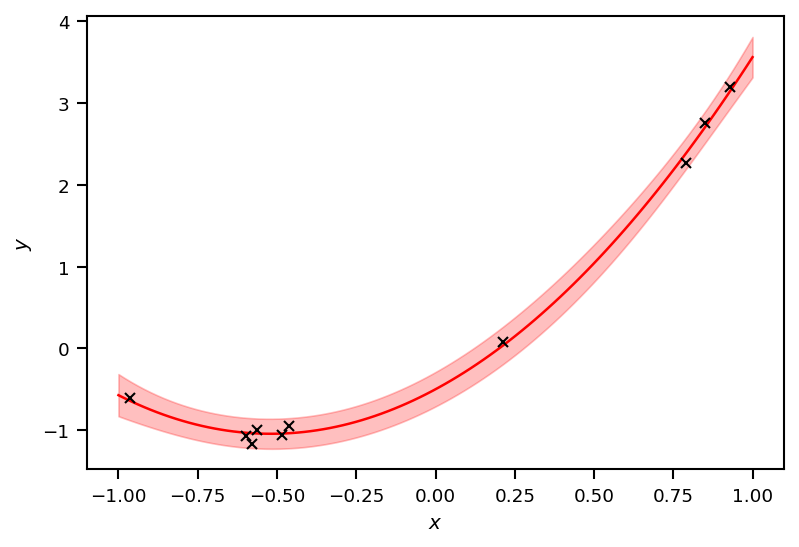

In [95]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean, yy_std = model.predict(Phi_xx, return_std=True)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
sigma2 = 0.1 ** 2
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
#yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
#yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
#ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
#ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

What if you wanted to get the samples from the posterior?
You would have to do a little bit of manual work to translate the posterior weights and their variance back to the original values...

In [ ]:
# Do later

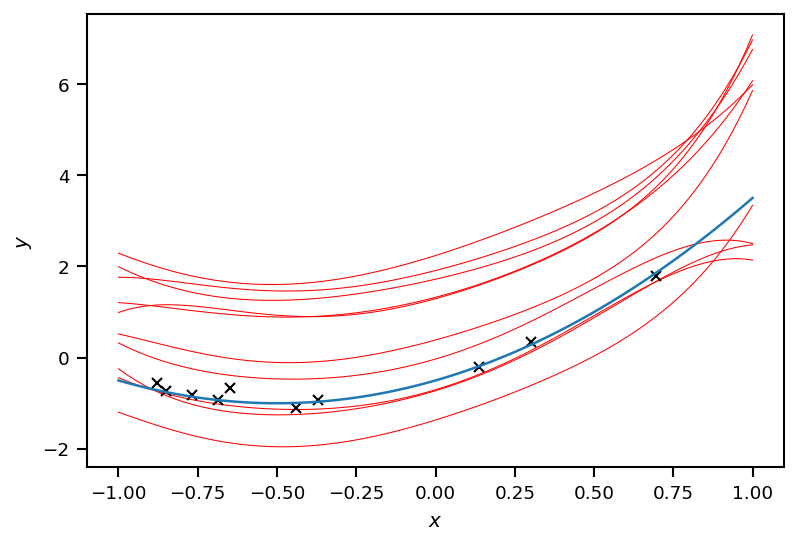

In [25]:
w_post = 
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

ValueError: too many values to unpack (expected 2)

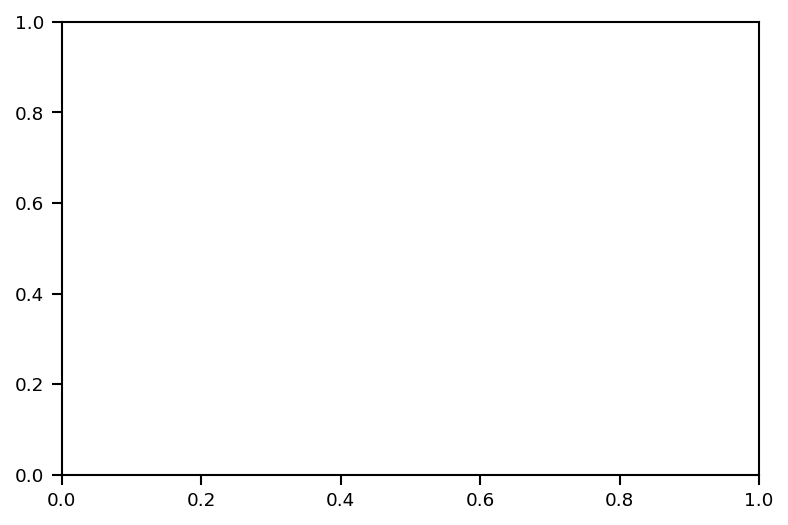

In [26]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
#yy_mean = np.dot(Phi_xx, m)
#yy_var = np.einsum('ij,jk,ik->i', Phi_xx, S, Phi_xx)
yy_mean, yy_var = model.predict(Phi_xx)
sigma2 = 0.1 ** 2
yy_measured_var = yy_var + sigma2
yy_std = np.sqrt(yy_var)
yy_measured_std = np.sqrt(yy_measured_var)
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.plot(xx, yy_mean, 'r')
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');